# IF3170 Artificial Intelligence | Tugas Besar 2



Group Number: 33

Group Members:
- Maximilian Sulistiyo (13522061)
- Marvel Pangondian (13522075)
- Evelyn Yosiana (13522083)
- Steven Tjhia (13522103)

## Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from collections import Counter
from scipy.spatial.distance import cdist
from imblearn.under_sampling import RandomUnderSampler
import optuna
import math
import copy

## Import Dataset

In [4]:
df_train_additional_feature = pd.read_csv("https://drive.google.com/uc?id=1W7U4Pb2iTfcNrpLnNGzatLtJyCbQnsdt")
df_train_basic_feature = pd.read_csv("https://drive.google.com/uc?id=1w2FaFHhRYVidatVcTd7QFiYS0Ja5bgug")
df_train_content_feature = pd.read_csv("https://drive.google.com/uc?id=1UP05jFMlbC_eyLDvAcgEtOke5tvJuQtJ")
df_train_flow_feature = pd.read_csv("https://drive.google.com/uc?id=1djRjRiyCNMc64UGeBNLdXia5E6HmGBYk")
df_train_time_feature = pd.read_csv("https://drive.google.com/uc?id=1-n6uIFE7OudouSSYMFqXgXx87UIZG5tQ")
df_train_label = pd.read_csv("https://drive.google.com/uc?id=1vBHLfOMsxBTWl1lCq920uFzW3gPoUYaN")

In [5]:
df_test_additional_feature = pd.read_csv("https://drive.google.com/uc?id=17nIiLyAggHjyYPv1SqM_pkoWiiJ16vI5")
df_test_basic_feature = pd.read_csv("https://drive.google.com/uc?id=1-A4gV5ua9L-BFQfQsxN9a92U56zLFZ6A")
df_test_content_feature = pd.read_csv("https://drive.google.com/uc?id=1u-P4PO6592yO0n2ixN1AuNfNznf-akoF")
df_test_flow_feature = pd.read_csv("https://drive.google.com/uc?id=1mmbadzV2Z4bEzUfxx-xzpYkyLiSqjMxL")
df_test_time_feature = pd.read_csv("https://drive.google.com/uc?id=1NBSciZh-u1Aw1yFUs4uGsxqBmm8I4MMw")

In [6]:
df_train = df_train_basic_feature.merge(df_train_additional_feature, on='id').merge(df_train_content_feature, on='id').merge(df_train_flow_feature, on='id').merge(df_train_time_feature, on='id').merge(df_train_label, on='id')
df_test = df_test_basic_feature.merge(df_test_additional_feature, on='id').merge(df_test_content_feature, on='id').merge(df_test_flow_feature, on='id').merge(df_test_time_feature, on='id')

In [7]:
categorical_features = ["proto", "state", "service", "is_sm_ips_ports", "is_ftp_login", "attack_cat"]
numerical_features = ["dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "sload", "dload", "spkts", "dpkts", "swin", "dwin", "stcpb", "dtcpb", "smean", "dmean", "trans_depth", "response_body_len", "sjit", "djit", "sinpkt", "dinpkt", "tcprtt", "synack", "ackdat", "ct_state_ttl", "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm"]

df_train_numeric = df_train[numerical_features]
df_train_categorical = df_train[categorical_features]
df_train_categorical['is_sm_ips_ports'] = df_train_categorical['is_sm_ips_ports'].astype('object')

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\3406893744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_categorical['is_sm_ips_ports'] = df_train_categorical['is_sm_ips_ports'].astype('object')


In [8]:
df_train.drop(columns=["id", "label"], inplace=True)
df_test.drop(columns=["id"], inplace=True)

# Exploratory Data Analysis (Optional)

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [9]:
df_train

,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
0,FIN,2.736664,13350.0,548216.0,31.0,29.0,21.0,197.0,-,3.885899e+04,...,0.0,tcp,4449.110313,3234.831566,11.845558,6.261361,NaN,0.000444,0.000114,Normal
1,INT,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.066666e+07,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,NaN,Generic
2,FIN,5.788526,6102.0,3892.0,254.0,252.0,13.0,13.0,-,8.199669e+03,...,0.0,tcp,8561.040438,249.950547,165.386453,172.345750,0.158826,0.057902,0.100924,Exploits
3,FIN,3.849634,25160.0,NaN,31.0,29.0,38.0,390.0,-,5.216912e+04,...,0.0,tcp,4053.086020,2918.730804,8.669644,4.496707,0.000558,0.000448,NaN,Normal
4,CON,0.001052,130.0,162.0,NaN,29.0,0.0,0.0,dns,4.942966e+05,...,0.0,udp,0.000000,0.000000,0.008000,0.007000,0.000000,0.000000,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,INT,0.000005,114.0,0.0,254.0,0.0,0.0,0.0,dns,9.120000e+07,...,0.0,udp,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000,Generic
175337,FIN,4.449357,1272.0,1634.0,62.0,NaN,7.0,NaN,ftp,2.191777e+03,...,NaN,tcp,15464.286700,531.848125,193.445428,209.600766,0.066524,0.047738,0.018786,Exploits
175338,INT,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.700000e+07,...,0.0,udp,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,Generic
175339,INT,0.000004,114.0,0.0,254.0,0.0,0.0,0.0,dns,1.140000e+08,...,0.0,udp,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,NaN,Generic


In [10]:
df_train

,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
0,FIN,2.736664,13350.0,548216.0,31.0,29.0,21.0,197.0,-,3.885899e+04,...,0.0,tcp,4449.110313,3234.831566,11.845558,6.261361,NaN,0.000444,0.000114,Normal
1,INT,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.066666e+07,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,NaN,Generic
2,FIN,5.788526,6102.0,3892.0,254.0,252.0,13.0,13.0,-,8.199669e+03,...,0.0,tcp,8561.040438,249.950547,165.386453,172.345750,0.158826,0.057902,0.100924,Exploits
3,FIN,3.849634,25160.0,NaN,31.0,29.0,38.0,390.0,-,5.216912e+04,...,0.0,tcp,4053.086020,2918.730804,8.669644,4.496707,0.000558,0.000448,NaN,Normal
4,CON,0.001052,130.0,162.0,NaN,29.0,0.0,0.0,dns,4.942966e+05,...,0.0,udp,0.000000,0.000000,0.008000,0.007000,0.000000,0.000000,0.000000,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,INT,0.000005,114.0,0.0,254.0,0.0,0.0,0.0,dns,9.120000e+07,...,0.0,udp,0.000000,0.000000,0.005000,0.000000,0.000000,0.000000,0.000000,Generic
175337,FIN,4.449357,1272.0,1634.0,62.0,NaN,7.0,NaN,ftp,2.191777e+03,...,NaN,tcp,15464.286700,531.848125,193.445428,209.600766,0.066524,0.047738,0.018786,Exploits
175338,INT,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.700000e+07,...,0.0,udp,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,Generic
175339,INT,0.000004,114.0,0.0,254.0,0.0,0.0,0.0,dns,1.140000e+08,...,0.0,udp,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,NaN,Generic


In [11]:
shape = df_train.shape
print(f"instance: {shape[0]}")
print(f"feature: {shape[1]}")

instance: 175341
feature: 42


In [12]:
df_train.dtypes

state                 object
dur                  float64
sbytes               float64
dbytes               float64
sttl                 float64
dttl                 float64
sloss                float64
dloss                float64
service               object
sload                float64
dload                float64
spkts                float64
dpkts                float64
is_sm_ips_ports      float64
ct_state_ttl         float64
ct_flw_http_mthd     float64
is_ftp_login         float64
ct_ftp_cmd           float64
ct_srv_src           float64
ct_srv_dst           float64
ct_dst_ltm           float64
ct_src_ltm           float64
ct_src_dport_ltm     float64
ct_dst_sport_ltm     float64
ct_dst_src_ltm       float64
swin                 float64
dwin                 float64
stcpb                float64
dtcpb                float64
smean                float64
dmean                float64
trans_depth          float64
response_body_len    float64
proto                 object
sjit          

In [13]:
unique_values = {col: df_train[col].nunique() for col in df_train_categorical.columns}
unique_values

{'proto': 133,
 'state': 9,
 'service': 13,
 'is_sm_ips_ports': 2,
 'is_ftp_login': 4,
 'attack_cat': 10}

In [14]:
for col in df_train_categorical.columns:
    print(f"Column: {col}")
    value_counts = df_train[col].value_counts()
    for value, count in value_counts.items():
        print(f" {value}: {count}")
    print("-" * 40)

Column: proto
 tcp: 75902
 udp: 60105
 unas: 11480
 arp: 2726
 ospf: 2468
 sctp: 1097
 any: 278
 gre: 216
 pim: 196
 mobile: 196
 swipe: 195
 sun-nd: 194
 ipv6: 194
 sep: 186
 rsvp: 185
 iatp: 99
 ib: 98
 cpnx: 98
 wb-mon: 98
 mfe-nsp: 98
 iplt: 98
 smp: 97
 3pc: 97
 ax.25: 97
 l2tp: 97
 i-nlsp: 97
 sprite-rpc: 97
 compaq-peer: 97
 sps: 97
 bna: 97
 gmtp: 97
 leaf-1: 97
 il: 96
 idrp: 96
 wb-expak: 96
 eigrp: 96
 uti: 96
 tcf: 96
 ipcomp: 96
 scps: 96
 tlsp: 96
 nsfnet-igp: 96
 pnni: 96
 skip: 96
 netblt: 96
 isis: 96
 xtp: 96
 iso-ip: 96
 sccopmce: 96
 ddp: 96
 trunk-2: 96
 trunk-1: 96
 vmtp: 96
 cftp: 96
 secure-vmtp: 96
 crtp: 96
 mtp: 95
 pup: 95
 dcn: 95
 st2: 95
 ipv6-route: 95
 sat-mon: 95
 vrrp: 95
 br-sat-mon: 95
 kryptolan: 95
 fire: 95
 ipv6-opts: 95
 ifmp: 95
 ipv6-no: 95
 rdp: 95
 snp: 95
 ttp: 95
 ipv6-frag: 95
 idpr-cmtp: 95
 idpr: 95
 xns-idp: 94
 vines: 94
 ip: 94
 aes-sp3-d: 94
 pri-enc: 94
 ptp: 94
 mhrp: 94
 srp: 94
 pipe: 94
 chaos: 94
 micp: 94
 cphb: 94
 cbt: 94


In [15]:
statistics = df_train_numeric.describe()
print("Statistics for Nuumeric Features:")
print("-" * 60)
for column in statistics.columns:
    print(f"Feature: {column}")
    print(f"  Minimum: {statistics.loc['min', column]:.2f}")
    print(f"  Maximum: {statistics.loc['max', column]:.2f}")
    print(f"  Mean: {statistics.loc['mean', column]:.2f}")
    print(f"  Median: {statistics.loc['50%', column]:.2f}")
    print(f"  Standard Deviation: {statistics.loc['std', column]:.2f}")
    print("-" * 60)

Statistics for Nuumeric Features:
------------------------------------------------------------
Feature: dur
  Minimum: 0.00
  Maximum: 60.00
  Mean: 1.36
  Median: 0.00
  Standard Deviation: 6.49
------------------------------------------------------------
Feature: sbytes
  Minimum: 28.00
  Maximum: 12965233.00
  Mean: 8734.08
  Median: 450.00
  Standard Deviation: 171228.85
------------------------------------------------------------
Feature: dbytes
  Minimum: 0.00
  Maximum: 14655550.00
  Mean: 14935.89
  Median: 164.00
  Standard Deviation: 143015.04
------------------------------------------------------------
Feature: sttl
  Minimum: 0.00
  Maximum: 255.00
  Mean: 179.52
  Median: 254.00
  Standard Deviation: 102.96
------------------------------------------------------------
Feature: dttl
  Minimum: 0.00
  Maximum: 254.00
  Mean: 79.58
  Median: 29.00
  Standard Deviation: 110.49
------------------------------------------------------------
Feature: sloss
  Minimum: 0.00
  Maximum:

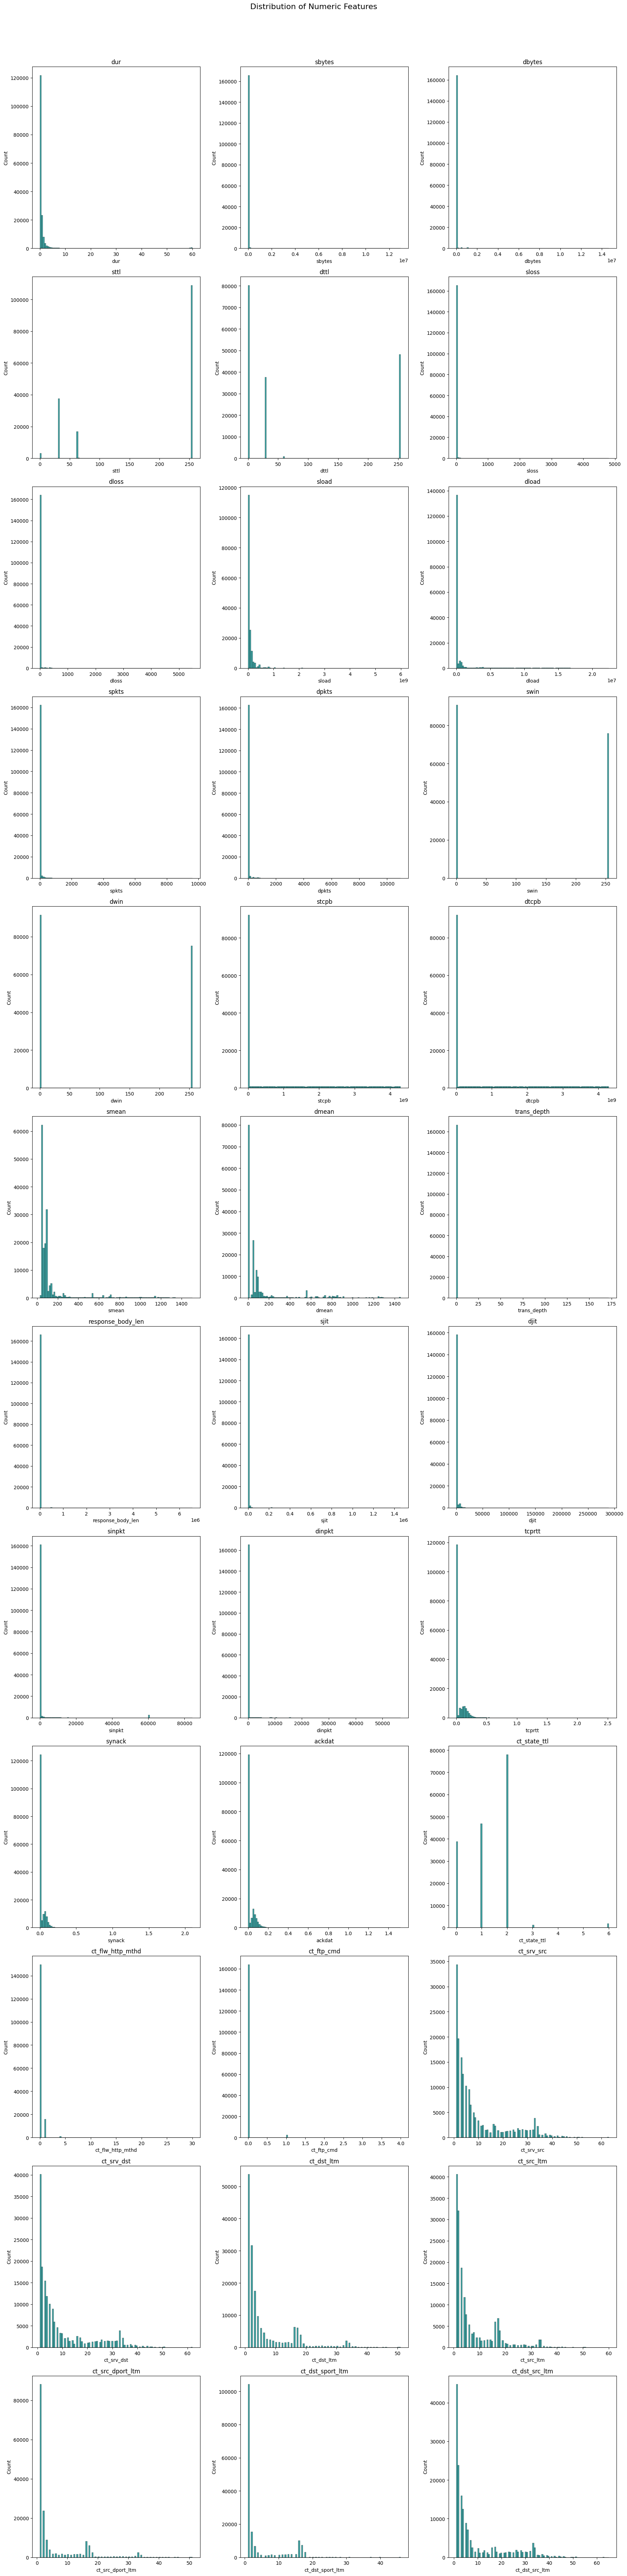

In [16]:
filtered_features = [feature for feature in df_train_numeric if feature != "id"]
num_features = len(filtered_features)

cols = 3
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

for idx, feature in enumerate(filtered_features):
    sns.histplot(df_train[feature], bins=100, color="teal", ax=axes[idx])
    axes[idx].set_title(feature)

for i in range(num_features, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Distribution of Numeric Features", fontsize=16, y=1.02)
plt.show()


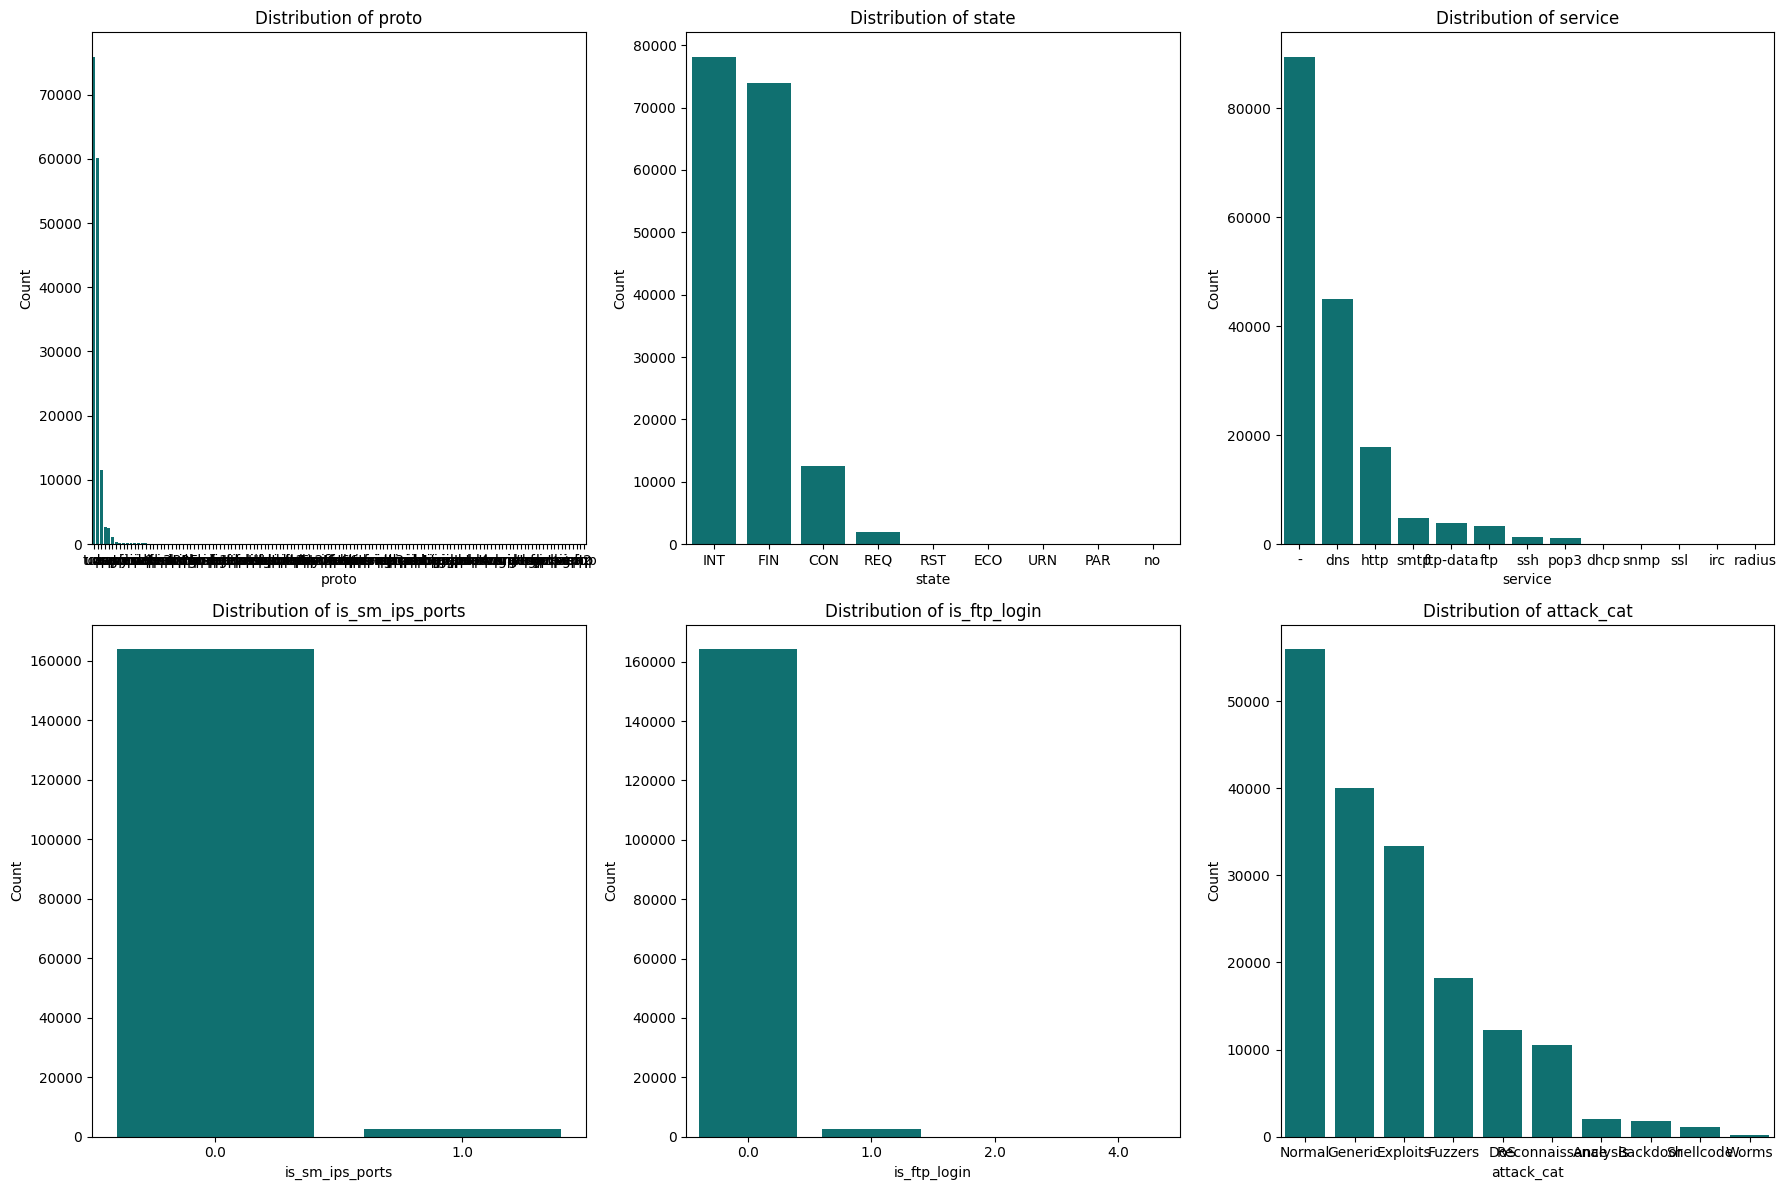

In [17]:
filtered_features = [feature for feature in df_train_categorical.columns]
num_features = len(filtered_features)

cols = 3
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

for idx, feature in enumerate(filtered_features):
    counts_df = df_train_categorical[feature].value_counts().reset_index()
    counts_df.columns = [feature, 'count']

    sns.barplot(data=counts_df, x=feature, y='count', color="teal", ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature}")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Count")

for i in range(len(filtered_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

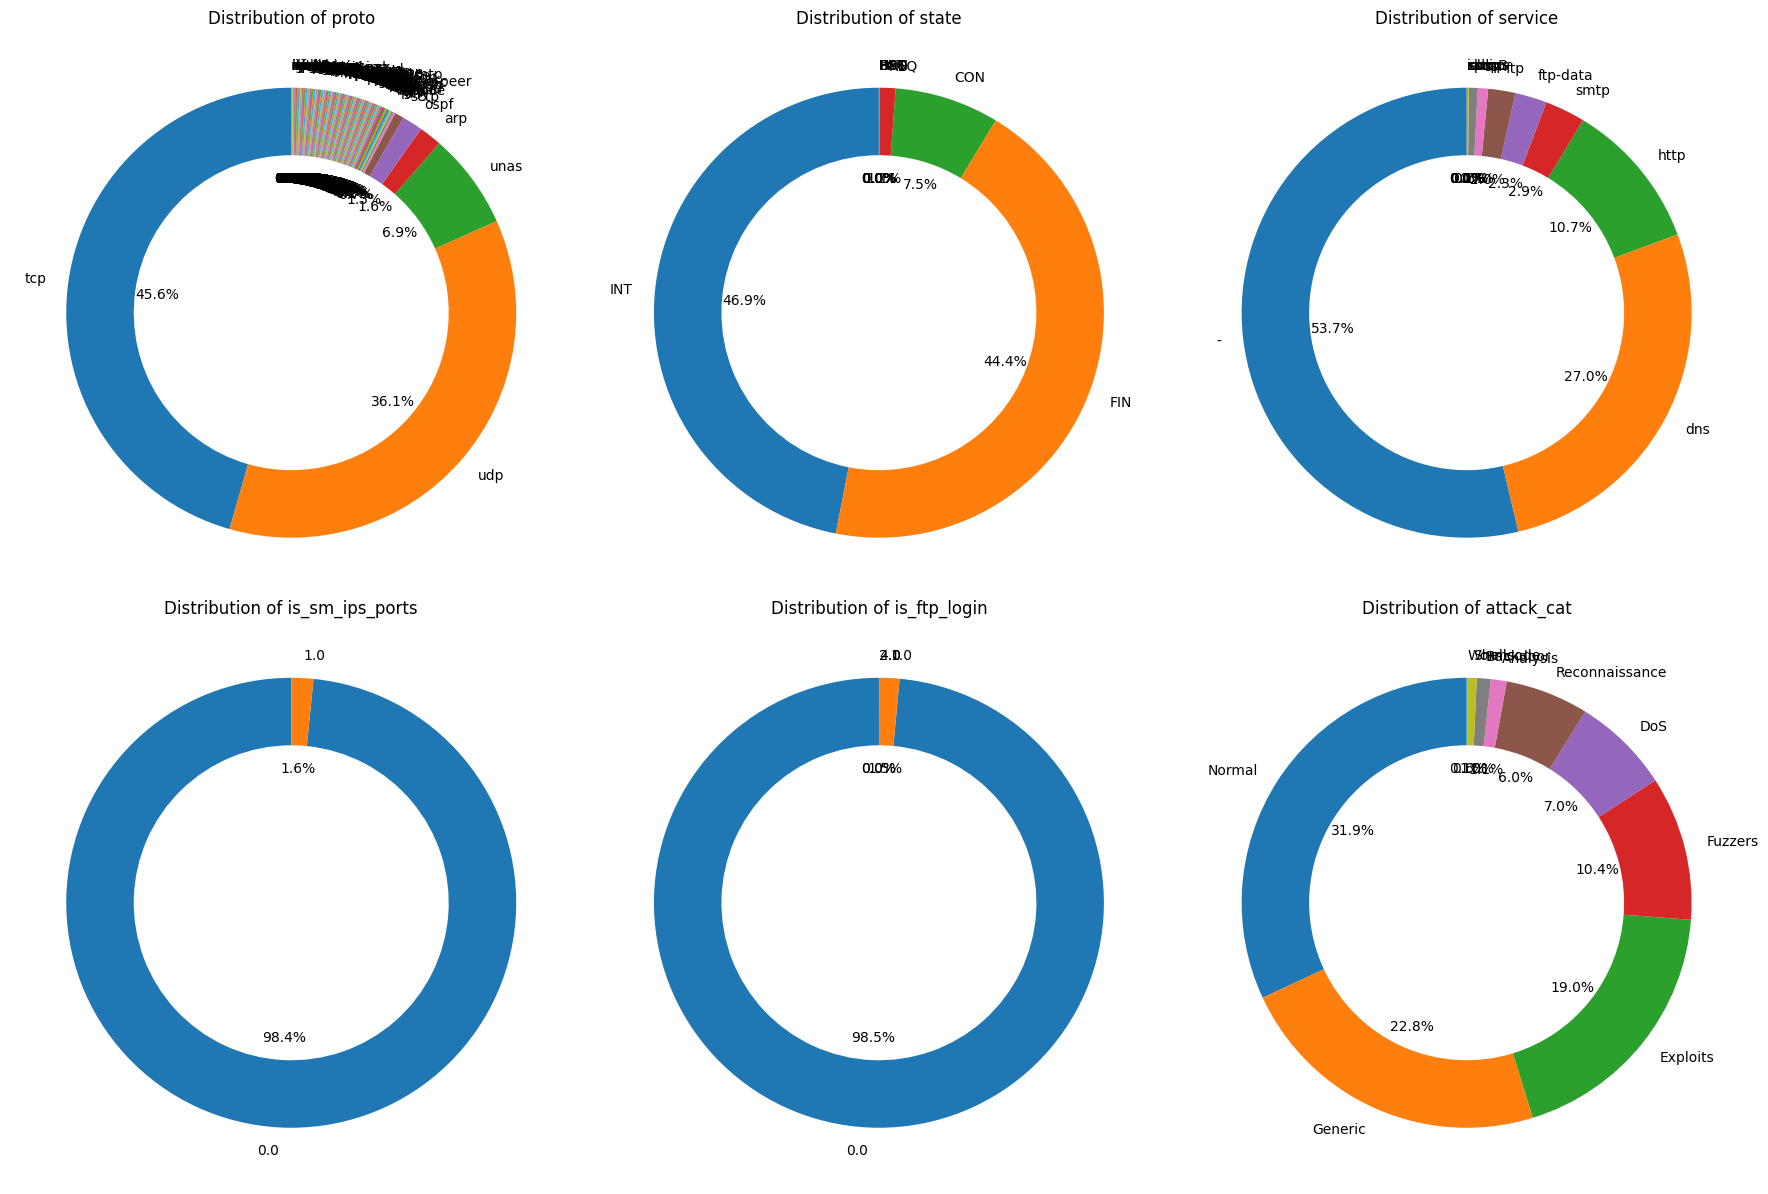

In [18]:
filtered_features = [feature for feature in df_train_categorical.columns]
num_features = len(filtered_features)

cols = 3
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 6))
axes = axes.flatten()

for idx, feature in enumerate(filtered_features):
    counts_df = df_train_categorical[feature].value_counts()
    labels = counts_df.index
    sizes = counts_df.values

    axes[idx].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.3})
    axes[idx].set_title(f"Distribution of {feature}")

for i in range(len(filtered_features), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\185931649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, ax=axes[i], palette="spring")
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\185931649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, ax=axes[i], palette="spring")
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\185931649.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=column, ax=axes[i], palette="spring")
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\185931649.py:11

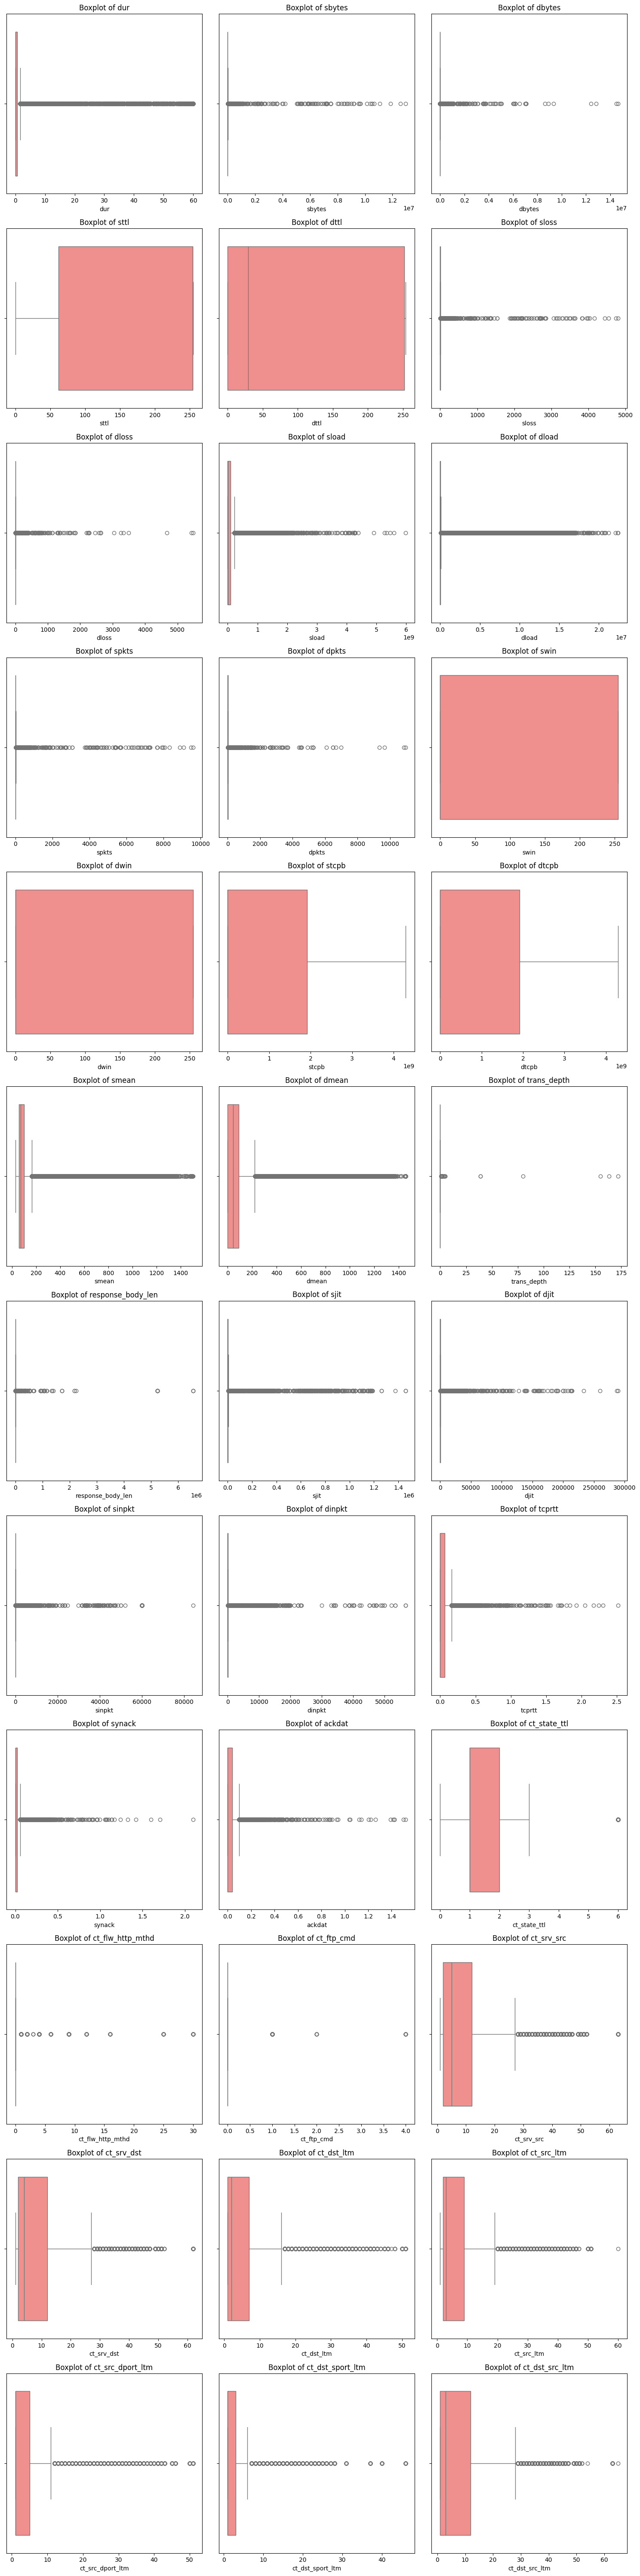

In [19]:
def plot_boxplots(df, columns_per_row=3):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    num_columns = len(numeric_columns)

    num_rows = (num_columns + columns_per_row - 1) // columns_per_row

    fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(columns_per_row * 5, num_rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=df, x=column, ax=axes[i], palette="spring")
        axes[i].set_title(f"Boxplot of {column}")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_boxplots(df_train_numeric)

# 1. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train` folder given by the TA. The `test` data is only used for kaggle submission.

Train : val = 80 : 20

In [20]:
train_set, val_set = train_test_split(df_train, train_size=0.8, random_state=42)

In [21]:
train_set

,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
96203,FIN,0.778778,608.0,646.0,254.0,252.0,2.0,3.0,-,5.629332e+03,...,0.0,NaN,4604.553147,102.742672,86.430667,81.175219,0.122210,0.048200,0.074010,Normal
58960,INT,0.000009,200.0,0.0,254.0,NaN,0.0,0.0,-,8.888889e+07,...,0.0,mhrp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,0.000000,Exploits
65069,INT,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.066666e+07,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,0.000000,Generic
64133,INT,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.700000e+07,...,0.0,udp,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,Generic
111445,FIN,0.627731,818.0,1062.0,62.0,252.0,2.0,2.0,http,9.392558e+03,...,249.0,tcp,3454.559695,115.159023,69.747889,74.994711,0.203372,0.102021,0.101351,Analysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,FIN,1.240960,10988.0,354.0,254.0,252.0,5.0,1.0,-,6.641310e+04,...,0.0,tcp,6282.365879,240.295547,82.730666,159.926422,0.143100,0.101635,0.041465,DoS
103694,FIN,0.949207,564.0,354.0,254.0,252.0,2.0,1.0,-,4.281469e+03,...,0.0,tcp,6986.891881,182.607109,102.387556,126.500711,0.135252,0.063701,0.071551,Reconnaissance
131932,INT,0.000002,114.0,NaN,254.0,0.0,0.0,0.0,dns,2.280000e+08,...,0.0,udp,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,0.000000,Generic
146867,INT,0.000003,NaN,0.0,NaN,0.0,0.0,0.0,dns,1.520000e+08,...,0.0,udp,0.000000,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,Generic


# 2. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

We will give some common methods for you to try, but you only have to **at least implement one method for each process**. For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [22]:
train_set.isnull().sum()

state                7034
dur                  6957
sbytes               6836
dbytes               7069
sttl                 7022
dttl                 6937
sloss                7004
dloss                7209
service              7038
sload                7006
dload                7096
spkts                6959
dpkts                6918
is_sm_ips_ports      7028
ct_state_ttl         7000
ct_flw_http_mthd     6946
is_ftp_login         6910
ct_ftp_cmd           7057
ct_srv_src           7102
ct_srv_dst           7015
ct_dst_ltm           7004
ct_src_ltm           7028
ct_src_dport_ltm     7036
ct_dst_sport_ltm     7079
ct_dst_src_ltm       7086
swin                 6971
dwin                 6999
stcpb                6941
dtcpb                7072
smean                7008
dmean                7078
trans_depth          7001
response_body_len    6999
proto                7033
sjit                 7015
djit                 7109
sinpkt               6953
dinpkt               6999
tcprtt      

## A. Data Cleaning

**Data cleaning** is the crucial first step in preparing your dataset for machine learning. Raw data collected from various sources is often messy and may contain errors, missing values, and inconsistencies. Data cleaning involves the following steps:

1. **Handling Missing Data:** Identify and address missing values in the dataset. This can include imputing missing values, removing rows or columns with excessive missing data, or using more advanced techniques like interpolation.

2. **Dealing with Outliers:** Identify and handle outliers, which are data points significantly different from the rest of the dataset. Outliers can be removed or transformed to improve model performance.

3. **Data Validation:** Check for data integrity and consistency. Ensure that data types are correct, categorical variables have consistent labels, and numerical values fall within expected ranges.

4. **Removing Duplicates:** Identify and remove duplicate rows, as they can skew the model's training process and evaluation metrics.

5. **Feature Engineering**: Create new features or modify existing ones to extract relevant information. This step can involve scaling, normalizing, or encoding features for better model interpretability.

### I. Handling Missing Data

Missing data can adversely affect the performance and accuracy of machine learning models. There are several strategies to handle missing data in machine learning:

1. **Data Imputation:**

    a. **Mean, Median, or Mode Imputation:** For numerical features, you can replace missing values with the mean, median, or mode of the non-missing values in the same feature. This method is simple and often effective when data is missing at random.

    b. **Constant Value Imputation:** You can replace missing values with a predefined constant value (e.g., 0) if it makes sense for your dataset and problem.

    c. **Imputation Using Predictive Models:** More advanced techniques involve using predictive models to estimate missing values. For example, you can train a regression model to predict missing numerical values or a classification model to predict missing categorical values.

2. **Deletion of Missing Data:**

    a. **Listwise Deletion:** In cases where the amount of missing data is relatively small, you can simply remove rows with missing values from your dataset. However, this approach can lead to a loss of valuable information.

    b. **Column (Feature) Deletion:** If a feature has a large number of missing values and is not critical for your analysis, you can consider removing that feature altogether.

3. **Domain-Specific Strategies:**

    a. **Domain Knowledge:** In some cases, domain knowledge can guide the imputation process. For example, if you know that missing values are related to a specific condition, you can impute them accordingly.

4. **Imputation Libraries:**

    a. **Scikit-Learn:** Scikit-Learn provides a `SimpleImputer` class that can handle basic imputation strategies like mean, median, and mode imputation.

    b. **Fancyimpute:** Fancyimpute is a Python library that offers more advanced imputation techniques, including matrix factorization, k-nearest neighbors, and deep learning-based methods.

The choice of imputation method should be guided by the nature of your data, the amount of missing data, the problem you are trying to solve, and the assumptions you are willing to make.

In [23]:
train_set.isnull().sum()

state                7034
dur                  6957
sbytes               6836
dbytes               7069
sttl                 7022
dttl                 6937
sloss                7004
dloss                7209
service              7038
sload                7006
dload                7096
spkts                6959
dpkts                6918
is_sm_ips_ports      7028
ct_state_ttl         7000
ct_flw_http_mthd     6946
is_ftp_login         6910
ct_ftp_cmd           7057
ct_srv_src           7102
ct_srv_dst           7015
ct_dst_ltm           7004
ct_src_ltm           7028
ct_src_dport_ltm     7036
ct_dst_sport_ltm     7079
ct_dst_src_ltm       7086
swin                 6971
dwin                 6999
stcpb                6941
dtcpb                7072
smean                7008
dmean                7078
trans_depth          7001
response_body_len    6999
proto                7033
sjit                 7015
djit                 7109
sinpkt               6953
dinpkt               6999
tcprtt      

In [24]:
null_counts = train_set.isnull().sum()
null_counts = null_counts.sort_values(ascending=False)
null_counts

dloss                7209
djit                 7109
ct_srv_src           7102
dload                7096
tcprtt               7093
ct_dst_src_ltm       7086
ct_dst_sport_ltm     7079
dmean                7078
dtcpb                7072
dbytes               7069
ct_ftp_cmd           7057
service              7038
ct_src_dport_ltm     7036
state                7034
proto                7033
ct_src_ltm           7028
is_sm_ips_ports      7028
sttl                 7022
ct_srv_dst           7015
sjit                 7015
smean                7008
sload                7006
ct_dst_ltm           7004
sloss                7004
trans_depth          7001
ct_state_ttl         7000
response_body_len    6999
dinpkt               6999
dwin                 6999
swin                 6971
spkts                6959
dur                  6957
sinpkt               6953
ct_flw_http_mthd     6946
synack               6943
stcpb                6941
dttl                 6937
dpkts                6918
is_ftp_login

In [25]:
top_null_rows = train_set.isnull().sum(axis=1).sort_values(ascending=False).head(50).reset_index()
top_null_rows.columns = ['id', 'Null Count']
print(top_null_rows)

        id  Null Count
0   141493          12
1   129445          10
2    25545          10
3   168421          10
4     8929          10
5   168934           9
6    11535           9
7    30699           9
8    69738           9
9    60615           9
10    2120           9
11    8620           9
12   81182           9
13   18278           9
14   76631           9
15  169853           9
16  130697           9
17   89128           9
18   29860           9
19   33867           9
20   29692           9
21   81266           8
22  160003           8
23  114258           8
24  114725           8
25   84811           8
26  116283           8
27   69496           8
28  128094           8
29   22474           8
30   93655           8
31   97653           8
32   57589           8
33   84873           8
34  119224           8
35   50214           8
36   55383           8
37   91707           8
38   76414           8
39  155153           8
40  150122           8
41   63297           8
42  127235 

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\2690715381.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_nulls = train_set_group.groupby('Group').apply(lambda group: group.isnull().sum())


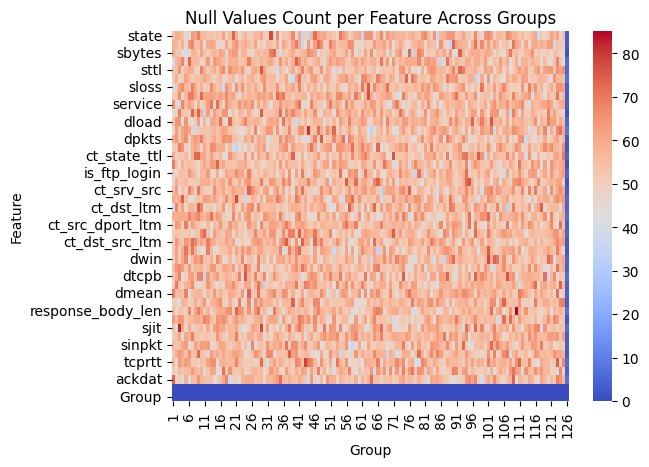

In [26]:
group_size = len(train_set) // 100
train_set_group = copy.deepcopy(train_set)
train_set_group['Group'] = np.ceil(train_set.index / group_size).astype(int)
grouped_nulls = train_set_group.groupby('Group').apply(lambda group: group.isnull().sum())

sns.heatmap(grouped_nulls.T, cmap='coolwarm', annot=False)
plt.title('Null Values Count per Feature Across Groups')
plt.xlabel('Group')
plt.ylabel('Feature')
plt.show()

In [27]:
threshold = len(train_set.columns) * 0.9
train_set_cleaned = train_set.dropna(thresh=threshold, axis=0)

In [28]:
train_set_cleaned

,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,sload,...,response_body_len,proto,sjit,djit,sinpkt,dinpkt,tcprtt,synack,ackdat,attack_cat
96203,FIN,0.778778,608.0,646.0,254.0,252.0,2.0,3.0,-,5.629332e+03,...,0.0,NaN,4604.553147,102.742672,86.430667,81.175219,0.122210,0.048200,0.074010,Normal
58960,INT,0.000009,200.0,0.0,254.0,NaN,0.0,0.0,-,8.888889e+07,...,0.0,mhrp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,0.000000,Exploits
65069,INT,0.000009,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.066666e+07,...,0.0,udp,0.000000,0.000000,0.009000,0.000000,0.000000,0.000000,0.000000,Generic
64133,INT,0.000008,114.0,0.0,254.0,0.0,0.0,0.0,dns,5.700000e+07,...,0.0,udp,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,Generic
111445,FIN,0.627731,818.0,1062.0,62.0,252.0,2.0,2.0,http,9.392558e+03,...,249.0,tcp,3454.559695,115.159023,69.747889,74.994711,0.203372,0.102021,0.101351,Analysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,FIN,1.240960,10988.0,354.0,254.0,252.0,5.0,1.0,-,6.641310e+04,...,0.0,tcp,6282.365879,240.295547,82.730666,159.926422,0.143100,0.101635,0.041465,DoS
103694,FIN,0.949207,564.0,354.0,254.0,252.0,2.0,1.0,-,4.281469e+03,...,0.0,tcp,6986.891881,182.607109,102.387556,126.500711,0.135252,0.063701,0.071551,Reconnaissance
131932,INT,0.000002,114.0,NaN,254.0,0.0,0.0,0.0,dns,2.280000e+08,...,0.0,udp,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,0.000000,Generic
146867,INT,0.000003,NaN,0.0,NaN,0.0,0.0,0.0,dns,1.520000e+08,...,0.0,udp,0.000000,0.000000,0.003000,0.000000,0.000000,0.000000,0.000000,Generic


In [29]:
def fill_null_values(df):

    df['proto'].fillna(df['proto'].mode()[0], inplace=True)

    df['state'].fillna(df['state'].mode()[0], inplace=True)

    if 'spkts' in df and 'dpkts' in df:
        df['dur'].fillna((df['spkts'] + df['dpkts']) / (df['sload'] + df['dload']), inplace=True)
    else:
        df['dur'].fillna(df['dur'].mean(), inplace=True) 

    if 'spkts' in df and 'smean' in df:
        df['sbytes'].fillna(df['spkts'] * df['smean'], inplace=True)
    if 'dpkts' in df and 'dmean' in df:
        df['dbytes'].fillna(df['dpkts'] * df['dmean'], inplace=True)

    df['sttl'].fillna(df['sttl'].mean(), inplace=True)
    df['dttl'].fillna(df['dttl'].mean(), inplace=True)

    if 'spkts' in df:
        df['sloss'].fillna(df['spkts'] * 0.01, inplace=True) 
    if 'dpkts' in df:
        df['dloss'].fillna(df['dpkts'] * 0.01, inplace=True)

    df['service'].fillna(df['service'].mode()[0], inplace=True)

    if 'dur' in df:
        df['sload'].fillna(df['sbytes'] / df['dur'], inplace=True)
        df['dload'].fillna(df['dbytes'] / df['dur'], inplace=True)

    df['spkts'].fillna(df['spkts'].mean(), inplace=True)
    df['dpkts'].fillna(df['dpkts'].mean(), inplace=True)

    df['swin'].fillna(df['swin'].mean(), inplace=True)
    df['dwin'].fillna(df['dwin'].mean(), inplace=True)

    df['stcpb'].fillna(df['stcpb'].mean(), inplace=True)
    df['dtcpb'].fillna(df['dtcpb'].mean(), inplace=True)

    if 'spkts' in df:
        df['smean'].fillna(df['sbytes'] / df['spkts'], inplace=True)
    if 'dpkts' in df:
        df['dmean'].fillna(df['dbytes'] / df['dpkts'], inplace=True)

    df['trans_depth'].fillna(df['trans_depth'].mode()[0], inplace=True)

    df['response_body_len'].fillna(df['response_body_len'].mean(), inplace=True)

    if 'dur' in df:
        df['sjit'].fillna(df['dur'] * 0.01, inplace=True)
        df['djit'].fillna(df['dur'] * 0.01, inplace=True)

    if 'spkts' in df:
        df['sinpkt'].fillna(df['dur'] / df['spkts'], inplace=True)
    if 'dpkts' in df:
        df['dinpkt'].fillna(df['dur'] / df['dpkts'], inplace=True)

    df['tcprtt'].fillna(df['synack'] + df['ackdat'], inplace=True)
    df['synack'].fillna(df['tcprtt'] - df['ackdat'], inplace=True)
    df['ackdat'].fillna(df['tcprtt'] - df['synack'], inplace=True)

    df['is_sm_ips_ports'].fillna(0, inplace=True)
    df['is_ftp_login'].fillna(0, inplace=True)

    count_features = [
        'ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 
        'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
    ]
    for feature in count_features:
        df[feature].fillna(df[feature].mean(), inplace=True)

    return df

In [30]:
train_set_cleaned = fill_null_values(train_set_cleaned)

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\3994973872.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['proto'].fillna(df['proto'].mode()[0], inplace=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\3994973872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['proto'].fillna(df['proto'].mode()[0], inplace=True)
C:\Users\

### II. Dealing with Outliers

Outliers are data points that significantly differ from the majority of the data. They can be unusually high or low values that do not fit the pattern of the rest of the dataset. Outliers can significantly impact model performance, so it is important to handle them properly.

Some methods to handle outliers:
1. **Imputation**: Replace with mean, median, or a boundary value.
2. **Clipping**: Cap values to upper and lower limits.
3. **Transformation**: Use log, square root, or power transformations to reduce their influence.
4. **Model-Based**: Use algorithms robust to outliers (e.g., tree-based models, Huber regression).

In [31]:
def clean_outliers(df):

    valid_states = ['ACC', 'CLO', 'CON', 'ECO', 'ECR', 'FIN', 'INT', 'MAS', 'PAR', 'REQ', 'RST', 'TST', 'TXD', 'URH', 'URN', '-']
    df = df[df['state'].isin(valid_states)]

    df = df[df['dur'] >= 0]

    df = df[(df['sbytes'] >= 0) & (df['dbytes'] >= 0)]

    df = df[(df['sttl'].between(0, 255)) & (df['dttl'].between(0, 255))]

    df = df[(df['spkts'] >= 0) & (df['dpkts'] >= 0)]

    df = df[(df['sjit'] >= 0) & (df['djit'] >= 0)]

    df = df[(df['sinpkt'] >= 0) & (df['dinpkt'] >= 0)]

    df = df[(df['tcprtt'] >= 0) & (df['synack'] >= 0) & (df['ackdat'] >= 0)]

    binary_columns = ['is_sm_ips_ports', 'is_ftp_login']
    for col in binary_columns:
        df = df[df[col].isin([0, 1])]

    df = df[df['trans_depth'] >= 0]
    df = df[df['response_body_len'] >= 0]

    df = df[(df['smean'] >= 0) & (df['dmean'] >= 0)]

    count_fields = ['ct_state_ttl', 'ct_flw_http_mthd', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst',
                    'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm']
    for field in count_fields:
        df = df[df[field] >= 0]

    return df

In [32]:
train_set_cleaned = clean_outliers(train_set_cleaned)

### III. Remove Duplicates
Handling duplicate values is crucial because they can compromise data integrity, leading to inaccurate analysis and insights. Duplicate entries can bias machine learning models, causing overfitting and reducing their ability to generalize to new data. They also inflate the dataset size unnecessarily, increasing computational costs and processing times. Additionally, duplicates can distort statistical measures and lead to inconsistencies, ultimately affecting the reliability of data-driven decisions and reporting. Ensuring data quality by removing duplicates is essential for accurate, efficient, and consistent analysis.

In [33]:
train_set_cleaned = train_set_cleaned.drop_duplicates()

### IV. Feature Engineering

**Feature engineering** involves creating new features (input variables) or transforming existing ones to improve the performance of machine learning models. Feature engineering aims to enhance the model's ability to learn patterns and make accurate predictions from the data. It's often said that "good features make good models."

1. **Feature Selection:** Feature engineering can involve selecting the most relevant and informative features from the dataset. Removing irrelevant or redundant features not only simplifies the model but also reduces the risk of overfitting.

2. **Creating New Features:** Sometimes, the existing features may not capture the underlying patterns effectively. In such cases, engineers create new features that provide additional information. For example:
   
   - **Polynomial Features:** Engineers may create new features by taking the square, cube, or other higher-order terms of existing numerical features. This can help capture nonlinear relationships.
   
   - **Interaction Features:** Interaction features are created by combining two or more existing features. For example, if you have features "length" and "width," you can create an "area" feature by multiplying them.

3. **Binning or Discretization:** Continuous numerical features can be divided into bins or categories. For instance, age values can be grouped into bins like "child," "adult," and "senior."

4. **Domain-Specific Feature Engineering:** Depending on the domain and problem, engineers may create domain-specific features. For example, in fraud detection, features related to transaction history and user behavior may be engineered to identify anomalies.

Feature engineering is both a creative and iterative process. It requires a deep understanding of the data, domain knowledge, and experimentation to determine which features will enhance the model's predictive power.

In [34]:
# Write your code here

## B. Data Preprocessing

**Data preprocessing** is a broader step that encompasses both data cleaning and additional transformations to make the data suitable for machine learning algorithms. Its primary goals are:

1. **Feature Scaling:** Ensure that numerical features have similar scales. Common techniques include Min-Max scaling (scaling to a specific range) or standardization (mean-centered, unit variance).

2. **Encoding Categorical Variables:** Machine learning models typically work with numerical data, so categorical variables need to be encoded. This can be done using one-hot encoding, label encoding, or more advanced methods like target encoding.

3. **Handling Imbalanced Classes:** If dealing with imbalanced classes in a binary classification task, apply techniques such as oversampling, undersampling, or using different evaluation metrics to address class imbalance.

4. **Dimensionality Reduction:** Reduce the number of features using techniques like Principal Component Analysis (PCA) or feature selection to simplify the model and potentially improve its performance.

5. **Normalization:** Normalize data to achieve a standard distribution. This is particularly important for algorithms that assume normally distributed data.

### Notes on Preprocessing processes

It is advised to create functions or classes that have the same/similar type of inputs and outputs, so you can add, remove, or swap the order of the processes easily. You can implement the functions or classes by yourself

or

use `sklearn` library. To create a new preprocessing component in `sklearn`, implement a corresponding class that includes:
1. Inheritance to `BaseEstimator` and `TransformerMixin`
2. The method `fit`
3. The method `transform`

### I. Feature Scaling

**Feature scaling** is a preprocessing technique used in machine learning to standardize the range of independent variables or features of data. The primary goal of feature scaling is to ensure that all features contribute equally to the training process and that machine learning algorithms can work effectively with the data.

Here are the main reasons why feature scaling is important:

1. **Algorithm Sensitivity:** Many machine learning algorithms are sensitive to the scale of input features. If the scales of features are significantly different, some algorithms may perform poorly or take much longer to converge.

2. **Distance-Based Algorithms:** Algorithms that rely on distances or similarities between data points, such as k-nearest neighbors (KNN) and support vector machines (SVM), can be influenced by feature scales. Features with larger scales may dominate the distance calculations.

3. **Regularization:** Regularization techniques, like L1 (Lasso) and L2 (Ridge) regularization, add penalty terms based on feature coefficients. Scaling ensures that all features are treated equally in the regularization process.

Common methods for feature scaling include:

1. **Min-Max Scaling (Normalization):** This method scales features to a specific range, typically [0, 1]. It's done using the following formula:

   $$X' = \frac{X - X_{min}}{X_{max} - X_{min}}$$

   - Here, $X$ is the original feature value, $X_{min}$ is the minimum value of the feature, and $X_{max}$ is the maximum value of the feature.  
<br />
<br />
2. **Standardization (Z-score Scaling):** This method scales features to have a mean (average) of 0 and a standard deviation of 1. It's done using the following formula:

   $$X' = \frac{X - \mu}{\sigma}$$

   - $X$ is the original feature value, $\mu$ is the mean of the feature, and $\sigma$ is the standard deviation of the feature.  
<br />
<br />
3. **Robust Scaling:** Robust scaling is a method that scales features to the interquartile range (IQR) and is less affected by outliers. It's calculated as:

   $$X' = \frac{X - Q1}{Q3 - Q1}$$

   - $X$ is the original feature value, $Q1$ is the first quartile (25th percentile), and $Q3$ is the third quartile (75th percentile) of the feature.  
<br />
<br />
4. **Log Transformation:** In cases where data is highly skewed or has a heavy-tailed distribution, taking the logarithm of the feature values can help stabilize the variance and improve scaling.

The choice of scaling method depends on the characteristics of your data and the requirements of your machine learning algorithm. **Min-max scaling and standardization are the most commonly used techniques and work well for many datasets.**

Scaling should be applied separately to each training and test set to prevent data leakage from the test set into the training set. Additionally, **some algorithms may not require feature scaling, particularly tree-based models.**

In [35]:
def min_max_scale(df, columns=None):
    scaler = MinMaxScaler()
    columns = columns or df.columns
    df[columns] = scaler.fit_transform(df[columns])
    return df

def standardize(df, columns=None):
    scaler = StandardScaler()
    columns = columns or df.columns
    df[columns] = scaler.fit_transform(df[columns])
    return df

def robust_scale(df, columns=None):
    scaler = RobustScaler()
    columns = columns or df.columns
    df[columns] = scaler.fit_transform(df[columns])
    return df

def log_transform(df, columns=None):
    columns = columns or df.columns
    df[columns] = np.log1p(df[columns])
    return df

### II. Feature Encoding

**Feature encoding**, also known as **categorical encoding**, is the process of converting categorical data (non-numeric data) into a numerical format so that it can be used as input for machine learning algorithms. Most machine learning models require numerical data for training and prediction, so feature encoding is a critical step in data preprocessing.

Categorical data can take various forms, including:

1. **Nominal Data:** Categories with no intrinsic order, like colors or country names.  

2. **Ordinal Data:** Categories with a meaningful order but not necessarily equidistant, like education levels (e.g., "high school," "bachelor's," "master's").

There are several common methods for encoding categorical data:

1. **Label Encoding:**

   - Label encoding assigns a unique integer to each category in a feature.
   - It's suitable for ordinal data where there's a clear order among categories.
   - For example, if you have an "education" feature with values "high school," "bachelor's," and "master's," you can encode them as 0, 1, and 2, respectively.
<br />
<br />
2. **One-Hot Encoding:**

   - One-hot encoding creates a binary (0 or 1) column for each category in a nominal feature.
   - It's suitable for nominal data where there's no inherent order among categories.
   - Each category becomes a new feature, and the presence (1) or absence (0) of a category is indicated for each row.
<br />
<br />
3. **Target Encoding (Mean Encoding):**

   - Target encoding replaces each category with the mean of the target variable for that category.
   - It's often used for classification problems.

In [36]:
OHEglobal = None

def label_encode(df, columns=None):
    le = LabelEncoder()
    columns = columns or df.columns  
    for column in columns:
        if df[column].dtype == 'object':  
            df[column] = le.fit_transform(df[column])
    return df

def one_hot_encode(df, columns=None, fit=True):
    global OHEglobal
    
    columns = columns or df.select_dtypes(include=['object']).columns
    df_copy = df.copy()
    column_data = df_copy[columns]

    column_data = column_data.apply(lambda col: col.fillna(col.mode()[0]) if col.isna().any() else col)

    if fit:
        OHEglobal = OneHotEncoder(drop=None, handle_unknown="ignore", sparse_output=False)
        encoded = OHEglobal.fit_transform(column_data)
        encoded_df = pd.DataFrame(
            encoded,
            columns=OHEglobal.get_feature_names_out(columns),
            index=df.index
        )
    else:
        encoded = OHEglobal.transform(column_data)
        encoded_df = pd.DataFrame(
            encoded,
            columns=OHEglobal.get_feature_names_out(columns),
            index=df.index
        )
    
    df_copy = df_copy.drop(columns=columns)
    df_copy = pd.concat([df_copy, encoded_df], axis=1)

    return df_copy

def target_encode(df, target_column, columns=None):
    columns = columns or df.columns 
    for column in columns:
        if df[column].dtype == 'object': 
            mean_target = df.groupby(column)[target_column].mean()
            df[column] = df[column].map(mean_target)
    return df

### III. Handling Imbalanced Dataset

**Handling imbalanced datasets** is important because imbalanced data can lead to several issues that negatively impact the performance and reliability of machine learning models. Here are some key reasons:

1. **Biased Model Performance**:

 - Models trained on imbalanced data tend to be biased towards the majority class, leading to poor performance on the minority class. This can result in misleading accuracy metrics.

2. **Misleading Accuracy**:

 - High overall accuracy can be misleading in imbalanced datasets. For example, if 95% of the data belongs to one class, a model that always predicts the majority class will have 95% accuracy but will fail to identify the minority class.

3. **Poor Generalization**:

 - Models trained on imbalanced data may not generalize well to new, unseen data, especially if the minority class is underrepresented.


Some methods to handle imbalanced datasets:
1. **Resampling Methods**:

 - Oversampling: Increase the number of instances in the minority class by duplicating or generating synthetic samples (e.g., SMOTE).
 - Undersampling: Reduce the number of instances in the majority class to balance the dataset.

2. **Evaluation Metrics**:

 - Use appropriate evaluation metrics such as precision, recall, F1-score, ROC-AUC, and confusion matrix instead of accuracy to better assess model performance on imbalanced data.

3. **Algorithmic Approaches**:

 - Use algorithms that are designed to handle imbalanced data, such as decision trees, random forests, or ensemble methods.
 - Adjust class weights in algorithms to give more importance to the minority class.

In [37]:
# def undersample_data(X, y, target_count=4000):

#     data = pd.concat([pd.DataFrame(X), pd.Series(y, name='label')], axis=1)

#     resampled_data = []
#     for label, group in data.groupby('label'):
#         if len(group) > target_count:
#             sampled_group = group.sample(n=target_count, random_state=42)
#         else:
#             sampled_group = group
#         resampled_data.append(sampled_group)

#     resampled_data = pd.concat(resampled_data)

#     print("Original class distribution:", Counter(y))
#     print("Resampled class distribution:", Counter(resampled_data['label']))

#     return resampled_data

In [81]:
def undersample_data(X, y, target_count=4000, upsample=False):
    
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    
    data = pd.concat([X, pd.Series(y, name='label')], axis=1)
    resampled_data = []
    
    for label, group in data.groupby('label'):
        if len(group) > target_count:
            sampled_group = group.sample(n=target_count, random_state=42)
        elif upsample and len(group) < target_count:
            sampled_group = group.sample(n=target_count, replace=True, random_state=42)
        else:
            sampled_group = group
        resampled_data.append(sampled_group)
    
    resampled_data = pd.concat(resampled_data)
    resampled_X = resampled_data.drop(columns=['label'])
    resampled_y = resampled_data['label']
    
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(resampled_y))
    
    return resampled_X, resampled_y

### IV. Data Normalization

Data normalization is used to achieve a standard distribution. Without normalization, models or processes that rely on the assumption of normality may not work correctly. Normalization helps reduce the magnitude effect and ensures numerical stability during optimization.

In [38]:
# Write your code here

### V. Dimensionality Reduction

Dimensionality reduction is a technique used in data preprocessing to reduce the number of input features (dimensions) in a dataset while retaining as much important information as possible. It is essential when dealing with high-dimensional data, where too many features can cause problems like increased computational costs, overfitting, and difficulty in visualization. Reducing dimensions simplifies the data, making it easier to analyze and improving the performance of machine learning models.

One of the main approaches to dimensionality reduction is feature extraction. Feature extraction creates new, smaller sets of features that capture the essence of the original data. Common techniques include:

1. **Principal Component Analysis (PCA)**: Converts correlated features into a smaller number of uncorrelated "principal components."
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)**: A visualization-focused method to project high-dimensional data into 2D or 3D spaces.
3. **Autoencoders**: Neural networks that learn compressed representations of the data.

In [39]:
# Write your code here

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [57]:
from sklearn.impute import SimpleImputer

def pipeline(df, fit=False):
    '''
    Params:
        df = dataframe to be pipelined
        fit = whether to perform fit or transform on df
    '''

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    for index, row in df.iterrows():
        if pd.isnull(row['sload']) and not pd.isnull(row['sbytes']) and not pd.isnull(row['dur']) and row['dur'] != 0:
            df.at[index, 'sload'] = row['sbytes'] * 8 / row['dur']
        if pd.isnull(row['dload']) and not pd.isnull(row['dbytes']) and not pd.isnull(row['dur']) and row['dur'] != 0:
            df.at[index, 'dload'] = row['dbytes'] * 8 / row['dur']

    categorical_features = ["proto", "state", "service", "is_sm_ips_ports", "is_ftp_login"]
    numerical_features = ["dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "sload", "dload", "spkts", "dpkts", "swin", "dwin", "stcpb", "dtcpb", "smean", "dmean", "trans_depth", "response_body_len", "sjit", "djit", "sinpkt", "dinpkt", "tcprtt", "synack", "ackdat", "ct_state_ttl", "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm"]

    one_hot_encode_column = ["proto", "state", "service"]
    label_encode_column = ["is_sm_ips_ports", "is_ftp_login"]
    target_encode_column = []

    min_max_scale_column = []
    standardize_column = [
        "dur", "sbytes", "dbytes", "sttl", "dttl", "sloss", "dloss", "sload", "dload", "spkts", "dpkts", "swin", "dwin", 
        "stcpb", "dtcpb", "smean", "dmean", "trans_depth", "response_body_len", "sjit", "djit", "sinpkt", "dinpkt", 
        "tcprtt", "synack", "ackdat", "ct_state_ttl", "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", 
        "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm"
    ]  
    robust_scale_column = []
    # log_transform_column = []
    log_transform_column = ["sload", "dload", "response_body_len", "sloss", "dloss"]

    # Impute Missing Values
    numerical_imputer = SimpleImputer(strategy='median')
    df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])

    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])
    
    # Encode 
    if one_hot_encode_column:
        df = one_hot_encode(df, columns=one_hot_encode_column, fit=fit)
    if label_encode_column:
        df = label_encode(df, columns=label_encode_column)
    if target_encode_column:
        for column in target_encode_column:
            df = target_encode(df, target_column=column)

    # Standardize 
    if standardize_column:
        df = standardize(df, columns=standardize_column)
    if min_max_scale_column:
        df = min_max_scale(df, columns=min_max_scale_column)
    if robust_scale_column:
        df = robust_scale(df, columns=robust_scale_column)
    if log_transform_column:
        df = log_transform(df, columns=log_transform_column)

    if df.isna().sum().sum() > 0:
        print("Warning: NAN!")
    
    return df


or create your own here

In [41]:
# Write your code here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the target feature `attack_cat`. Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [42]:
# Buat develop ID3 ajah

mini_df = copy.deepcopy(train_set)
mini_df = mini_df[mini_df['attack_cat'].isin(['Normal', 'Worms', 'Shellcode'])]
mini_df.drop(columns=["service", "is_sm_ips_ports", "is_ftp_login", "sttl", "dttl", "sloss", "dloss", "sload", "dload", "spkts", "dpkts", "swin", "dwin", "stcpb", "dtcpb", "smean", "dmean", "trans_depth", "response_body_len", "sjit", "djit", "sinpkt", "dinpkt", "tcprtt", "synack", "ackdat", "ct_state_ttl", "ct_flw_http_mthd", "ct_ftp_cmd", "ct_srv_src", "ct_srv_dst", "ct_dst_ltm", "ct_src_ltm", "ct_src_dport_ltm", "ct_dst_sport_ltm", "ct_dst_src_ltm", "attack_cat", "state", "proto"], inplace=True)
mini_df = mini_df.tail(10)
mini_y = pd.Series({'attack_cat': ['Normal', 'Worms', 'Shellcode', 'Normal', 'Worms', 'Shellcode', 'Normal', 'Worms', 'Shellcode', 'Normal']})

In [43]:
X_val = val_set.drop(columns='attack_cat')
y_val = val_set['attack_cat']
X_train = train_set_cleaned.drop(columns='attack_cat')
y_train = train_set_cleaned['attack_cat']

In [83]:
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train, target_count=500)

Original class distribution: Counter({'Normal': 40946, 'Generic': 22770, 'Exploits': 22750, 'Fuzzers': 13196, 'DoS': 7806, 'Reconnaissance': 7102, 'Analysis': 1421, 'Backdoor': 1206, 'Shellcode': 798, 'Worms': 90})
Resampled class distribution: Counter({'Analysis': 500, 'Backdoor': 500, 'DoS': 500, 'Exploits': 500, 'Fuzzers': 500, 'Generic': 500, 'Normal': 500, 'Reconnaissance': 500, 'Shellcode': 500, 'Worms': 90})


In [85]:
X_train_undersampled_pipelined = pipeline(X_train_undersampled, fit=True)
X_train_pipelined = pipeline(X_train, fit=True)
X_val_pipelined = pipeline(X_val)
df_test_pipelined = pipeline(df_test)

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\79035231.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\79035231.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\79035231.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

In [59]:
# Distance

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))

def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2), axis=1)

def minkowski_distance(x1, x2, p=3):
    return np.sum(np.abs(x1 - x2) ** p, axis=1) ** (1 / p)

## A. KNN

In [60]:
import numpy as np
from collections import Counter
from sklearn.neighbors import KDTree, BallTree
from scipy.spatial.distance import cdist

class KNN_Selfmade:
    def __init__(self, neighbors=3, metric='euclidean', p=3, algorithm='brute_force'):
        '''
        neighbors: jumlah tetangga (N) yang nantinya bakal diambil top N tetangga paling deket buat dicari modusnya dalam case binary classification
        metric: cara perhitungan jarak [euclidean, manhattan, minkowski]
        p: parameter order buat minkowski
        algorithm: [brute_force, kd_tree, ball_tree]
        '''
        self.neighbors = neighbors
        self.metric = metric
        self.p = p
        self.algorithm = algorithm
        self.tree = None

    def fit(self, X, y):
        self.X_train = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
        self.y_train = y.to_numpy() if hasattr(y, 'to_numpy') else np.array(y)

        if self.algorithm == 'kd_tree':
            self.tree = KDTree(self.X_train, metric=self.metric)
        elif self.algorithm == 'ball_tree':
            self.tree = BallTree(self.X_train, metric=self.metric)

    def predict(self, X):
        X = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
        predictions = []

        if self.tree:
            distances, indices = self.tree.query(X, k=self.neighbors)
            for i, neighbors_indices in enumerate(indices):
                # if i % 1000 == 0 and i > 0:
                #     print(f"Processed {i}/{X.shape[0]} data points")
                predictions.append(self._predict_single(neighbors_indices))
        else:
            distances = self._compute_distances(X)
            indices = np.argsort(distances, axis=1)[:, :self.neighbors]
            for i, neighbors_indices in enumerate(indices):
                # if i % 1000 == 0 and i > 0:
                #     print(f"Processed {i}/{X.shape[0]} data points")
                predictions.append(self._predict_single(neighbors_indices))

        return np.array(predictions)

    def _compute_distances(self, X):
        if self.metric == 'euclidean':
            return cdist(X, self.X_train, metric='euclidean')
        elif self.metric == 'manhattan':
            return cdist(X, self.X_train, metric='cityblock')
        elif self.metric == 'minkowski':
            return cdist(X, self.X_train, metric='minkowski', p=self.p)
        else:
            raise ValueError("Unsupported metric! Choose 'euclidean', 'manhattan', or 'minkowski'.")

    def _predict_single(self, neighbors_indices):
        top_n_labels = self.y_train[neighbors_indices]
        return Counter(top_n_labels).most_common(1)[0][0]


In [61]:
def objective(trial):
    neighbors = trial.suggest_int('neighbors', 1, 25)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    p = trial.suggest_int('p', 1, 10) if metric == 'minkowski' else 3

    model = KNN_Selfmade(neighbors=neighbors, metric=metric, p=p)
    model.fit(X_train_pipelined, y_train)
    
    predictions = model.predict(X_val_pipelined)
    
    f1 = f1_score(y_val, predictions, average='weighted')
    return f1

In [62]:
def tune_knn(X, y):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=100)
    print("Best hyperparameters:", study.best_params)
    print("Best F1 score:", study.best_value)

In [63]:
# tune_knn(X_train_pipelined, y_train)

In [87]:
X_val_pipelined.shape

(35069, 190)

In [86]:
X_train_undersampled_pipelined.shape

(4590, 184)

In [88]:
model_knn_selfmade = KNN_Selfmade(neighbors=4, metric='manhattan', algorithm='kd_tree')
model_knn_selfmade.fit(X_train_undersampled_pipelined, y_train_undersampled)
y_pred_knn_selfmade_for_val = model_knn_selfmade.predict(X_val_pipelined)
# y_pred_knn_selfmade_for_test = model_knn_selfmade.predict(df_test_pipelined)

ValueError: query data dimension must match training data dimension

## B. Naive Bayes

In [69]:
class Gaussian_Naive_Bayes_Selfmade:
    def __init__(self):
        '''
        classes : seluruh nilai prediksi (distinct)
        mean: rata-rata
        var: variansi
        priors: probabilitas awal
        '''
        self.classes = None
        self.mean = None
        self.var = None
        self.priors = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self.var = np.zeros((n_classes, n_features), dtype=np.float64)
        self.priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0, ddof=1) + 1e-9 # ditambah dikit biar ga 0 soalnya nanti kan jadi denominator ntar jadi NaN
            self.priors[idx] = X_c.shape[0] / float(n_samples)

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def _predict(self, x):
        posteriors = []
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            class_conditional = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self._predict(x) for x in X.to_numpy()])

In [70]:
model_naive_bayes_selfmade = Gaussian_Naive_Bayes_Selfmade()
model_naive_bayes_selfmade.fit(X_train_pipelined, y_train)
y_pred_naive_bayes_selfmade_for_val = model_naive_bayes_selfmade.predict(X_val_pipelined)
# y_pred_naive_bayes_selfmade_for_test = model_naive_bayes_selfmade.predict(df_test_pipelined)

C:\Users\ACER\AppData\Local\Temp\ipykernel_26560\2081828185.py:40: RuntimeWarning: divide by zero encountered in log
  class_conditional = np.sum(np.log(self._pdf(idx, x)))


## C. ID3

In [90]:
def entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return -np.sum(probabilities * np.log2(probabilities + 1e-9))

def information_gain_entropy(y, y_left, y_right):
    p_left = len(y_left) / len(y)
    p_right = 1 - p_left
    return entropy(y) - (p_left * entropy(y_left) + p_right * entropy(y_right))

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class ID3_Selfmade:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth if max_depth is not None else float('inf')
        self.min_samples_split = min_samples_split
        self.root = None
        self.label_mapping = None

    def fit(self, X, y):
        y_encoded, self.label_mapping = pd.factorize(y)
        self.root = self._grow_tree(X.values, y_encoded)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        best_feature, best_threshold = self._best_split(X, y, n_features)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_child = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_child = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(best_feature, best_threshold, left_child, right_child)

    def _best_split(self, X, y, n_features):
        best_gain = -1
        split_index, split_threshold = None, None

        for feature_index in range(n_features):
            thresholds, indices = np.unique(X[:, feature_index], return_inverse=True)
            for i, threshold in enumerate(thresholds):
                left_mask = indices <= i
                right_mask = ~left_mask
                
                y_left, y_right = y[left_mask], y[right_mask]
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                gain = information_gain_entropy(y, y_left, y_right)
                if gain > best_gain:
                    best_gain = gain
                    split_index = feature_index
                    split_threshold = threshold

        return split_index, split_threshold

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        predictions = np.array([self._traverse_tree(x, self.root) for x in X.values])
        return self.label_mapping[predictions]

    def _traverse_tree(self, x, node):
        while not node.is_leaf_node():
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


In [57]:
# model_ID3_selfmade = ID3_Selfmade()
# model_ID3_selfmade.fit(mini_df, mini_y)
# y_pred_ID3_selfmade = model_ID3_selfmade.predict(mini_df)

In [92]:
X_train_undersampled_pipelined.shape

(4590, 184)

In [91]:
model_ID3_selfmade = ID3_Selfmade(max_depth=15)
model_ID3_selfmade.fit(X_train_undersampled_pipelined, y_train_undersampled)
y_pred_ID3_selfmade_for_val = model_ID3_selfmade.predict(X_val_pipelined)
# y_pred_ID3_selfmade_for_test = model_ID3_selfmade.predict(df_test_pipelined)

## D. Improvements (Optional)

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

In [94]:
# Graph 
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
plot_confusion_matrix(y_val, y_pred_knn_selfmade_for_val, y_val.value_counts().index)

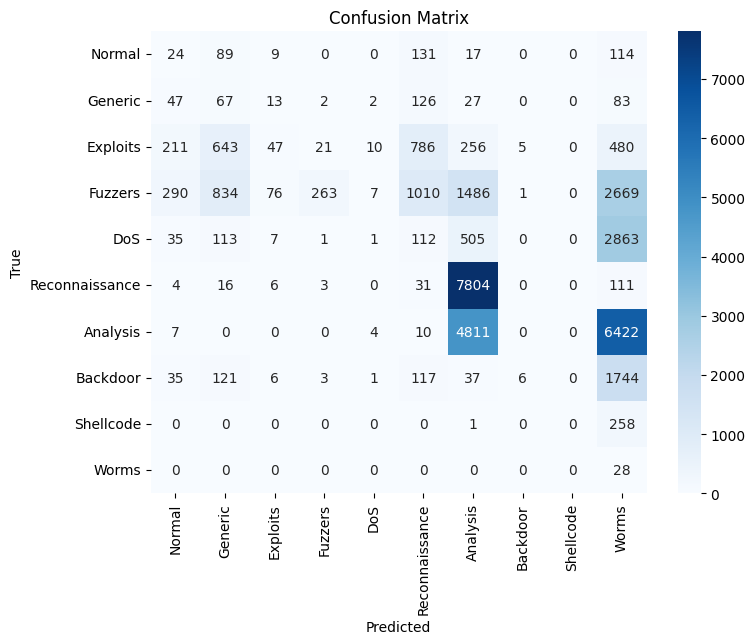

In [95]:
plot_confusion_matrix(y_val, y_pred_naive_bayes_selfmade_for_val, y_val.value_counts().index)

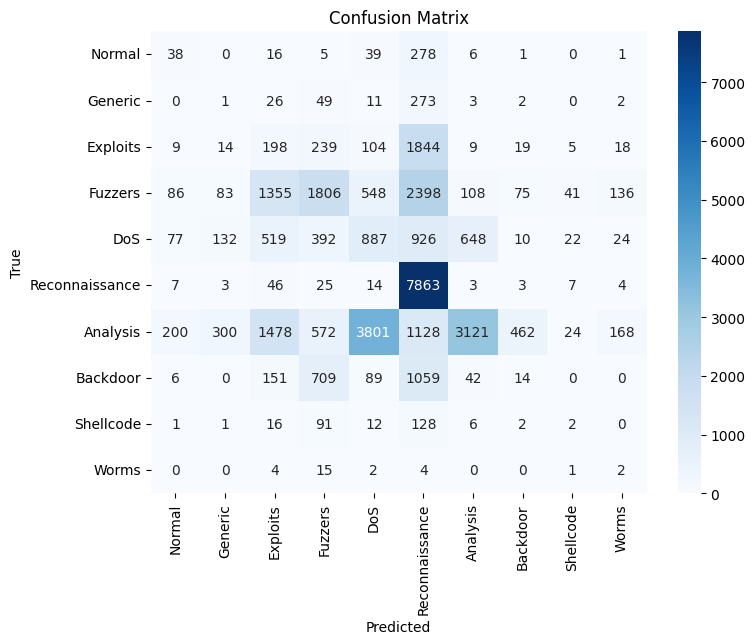

In [96]:
plot_confusion_matrix(y_val, y_pred_ID3_selfmade_for_val, y_val.value_counts().index)

## E. Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id` and `attack_cat` column.

In [ ]:
# # Kalo pake KNN
# predicting_model = "KNN"
# test_pred = y_pred_KNN_selfmade

In [145]:
# # Kalo pake Naive Bayes
# predicting_model = "Naive_Bayes"
# test_pred = y_pred_naive_bayes_selfmade

In [146]:
# # Kalo pake ID3
# predicting_model = "ID3"
# test_pred = y_pred_ID3_selfmade

In [147]:
submission_df = pd.DataFrame()
submission_df["id"] = range(len(test_pred))
submission_df["attack_cat"] = test_pred

In [148]:
from datetime import datetime

submission_df.to_csv(("submission-" + predicting_model + datetime.now().strftime("-%Y %m %d_%Hh %Mm %Ss") + ".csv") , index=False)

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

`Provide your analysis here`